<hr style="border:2px solid #0176DE"> </hr>
<center><h1 style="color:#173F8A;"> EMI 2024 - CMM Chile</h1></center>
<hr style="border:2px solid #0176DE"> </hr>
<h3 style="color:#173F8A;text-align:right;"> Profesores: &nbsp;Nicolás Barnafi<br>Manuel A. Sanchez<br></h3>

<h3 style="color:#03122E;text-align:right;"> 
    Centro de Modelamiento Matemático <br> 
    Instituto de Ingeniería Matemática y Computacional - IMC UC<br>  
</h3>

<hr style="border:2px solid #03122E"> </hr>
<center><h1 style="color:#173F8A;"> Módulo 4: Precondicionadores</h1></center> 
<hr style="border:2px solid #03122E"> </hr>

<!-- Palette colors UC:
Primaria: 
celeste:#0176DE, azul #173F8A, azul oscuro: #03122E, amarillo: #FEC60D, amarillo oscuro: #E3AE00 
Secundaria
gris oscuro: #707070
-->

# Preconditioners

From $A=M - N$ we had
    $$ Ax = b \quad \Leftrightarrow Mx^k = Nx^{k-1} + b $$
This gives the increment equation for $\delta x^k = x^k - x^{k-1}$:
    $$ M\delta x^k = b - Ax^{k-1} $$
This is a Richardson iteration for the following system:
    $$ M^{-1}Ax = M^{-1}b $$
We call $P^{-1}:=M^{-1}$ the preconditioner. We seek that
    $$ \rho(P^{-1} A) << \rho(A) $$

# Preconditioned systems

$$ P^{-1}Ax = P^{-1}b $$
    
- The *ideal* preconditioner is $P=A$ as $\rho(P^{-1}A) = 1$. We settle with $P\approx A$.
- Preconditioning can be "left" or "right" (or "symmetrical", which is purely theoretical)
    $$ P^{-1}Ax = P^{-1}b \qquad \text{or} \qquad (AP^{-1})(Px) = b $$
  Difference: Left preconditioning modifies residual (important for error control)
- $P$ can be any linear operator. E.g.: some iterations of an iterative method
- Typical preconditioners: Jacobi, Gauss-Seidel, SOR, ILU, IC, AMG, DD

# Jacobi
$$P = \mathrm{diag} A = \begin{bmatrix}a_{11} & 0 &  \\ 0 & a_{22} & 0  \\ & & \ddots \end{bmatrix}$$
This means trivially that
$$ P^{-1} = (\mathrm{diag} A)^{-1} = \begin{bmatrix}1/a_{11} & 0 & 0 \\ 0 & 1/a_{22} & 0 & \\ 0 & 0 & \ddots \end{bmatrix} $$

# Gauss-Seidel (lower)
$$ P = \mathrm{tril} A = \begin{bmatrix}a_{11} & 0 &  \\ a_{21} & a_{22} & 0  \\ & & \ddots \end{bmatrix}$$
This means that $P^{-1}$ is a forward substitution procedure.

# Gauss-Seidel (upper)
$$ P = \mathrm{triu} A = \begin{bmatrix}a_{11} & a_{12} &  \\ 0 & a_{22} & 0  \\ & & \ddots \end{bmatrix}$$
This means that $P^{-1}$ is a backward substitution procedure.

# Incomplete LU (ILU)

- The idea is to *almost* factorize
- Formulating an _almost_ factorization is non-trivial. Can you guess how?

# ILU(0)

ILU of matrix A:
1. For i=2, $\dots$, N:
2. &emsp;For k=1, $\dots$, i-1 and $\color{red}{(i,k)\in NZ(A)}$:
3. &emsp;&emsp;Set $A_{ik} = A_{ik} / A_{kk}$
4. &emsp;&emsp;For j=k+1, $\dots$, N and $\color{red}{ (i,j)\in NZ(A)}$:
5. &emsp;&emsp;&emsp;Set $A_{ij} = A_{ij} - A_{ik}A_{kj}$
6. &emsp;&emsp;End
7. &emsp;End
8. End

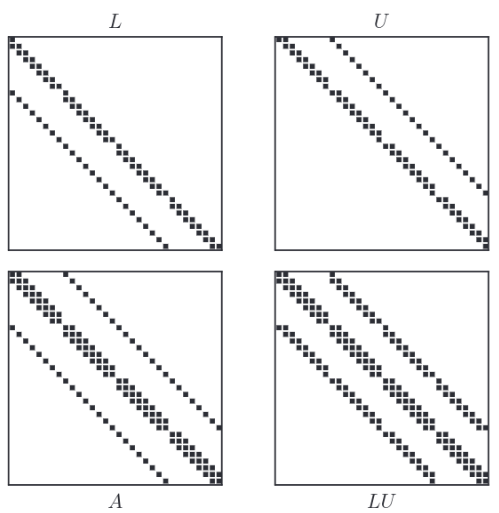

In [5]:
from IPython.display import Image; Image(filename='ilu0.png') 

# ILU(p)

Rough idea: the approximate LU is more dense than A

- Compute the sparsity pattern of L(0) and U(0) (not the values)
- Compute the sparsity pattern of PT(1)=L(0)U(0)
- Use PT(1) for the non-zero locations of the new factorization
- Repeat for ILU(p)

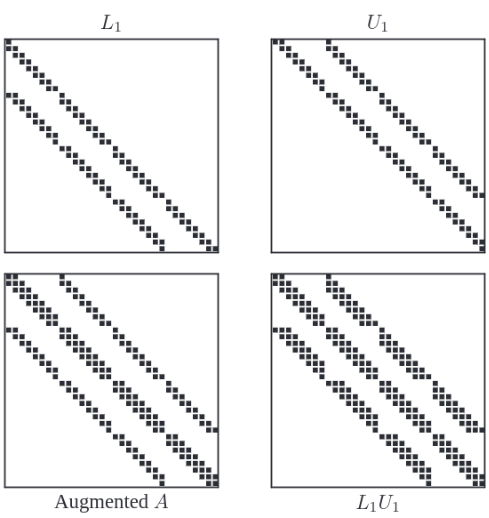

In [6]:
from IPython.display import Image; Image(filename='ilu1.png') 

# Hand on

Let's implement Jacobi, GS, ILU and see how they improve the convergence of CG.

In [55]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
import scipy.sparse as sp
from scipy.sparse.linalg import spilu
import matplotlib.pylab as plt
from ngsolve.la import EigenValues_Preconditioner
import pandas as pd
from ngsolve.krylovspace import CGSolver, GMRESSolver

In [56]:
def getSystem(maxh, p):
    shape = Rectangle(1,1).Face()
    geo = OCCGeometry(shape, dim=2)
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    V = H1(mesh, order=p)
    u, v = V.TnT()
    form = InnerProduct(Grad(u), Grad(v))*dx + u * v * dx
    a = BilinearForm(form).Assemble()
    f = LinearForm(v*dx).Assemble()
    gf = GridFunction(V)
    return a, f, gf, V

In [57]:
# We can define our own abstract preconditioners through the NGSolve interface

class NoPrec(BaseMatrix):
    def __init__ (self, a):
        super(NoPrec, self).__init__()
        self.a = a
    def Mult (self, x, y):
        y[:] = x
    def Height (self):
        return self.a.mat.shape[0]
    def Width (self):
        return self.a.mat.shape[1]

In [58]:
class Jacobi(BaseMatrix):
    def __init__ (self, smoother):
        super(Jacobi, self).__init__()
        self.smoother = smoother
        self.steps = steps
    def Mult (self, x, y):
        y[:] = 0.0
        self.smoother.Mult(x, y)
    def Height (self):
        return self.smoother.height
    def Width (self):
        return self.smoother.height


In [59]:
class GaussSeidelL(BaseMatrix):
    def __init__ (self, smoother):
        super(GaussSeidelL, self).__init__()
        self.smoother = smoother
    def Mult (self, x, y):
        y[:] = 0.0
        self.smoother.Smooth(y, x)
    def Height (self):
        return self.smoother.height
    def Width (self):
        return self.smoother.height

In [60]:
class GaussSeidelU(BaseMatrix):
    def __init__ (self, smoother, steps=1):
        super(GaussSeidelU, self).__init__()
        self.smoother = smoother
        self.steps = steps
    def Mult (self, x, y):
        y[:] = 0.0
        self.smoother.SmoothBack(y, x)
    def Height (self):
        return self.smoother.height
    def Width (self):
        return self.smoother.height

In [61]:
class GaussSeidelSym(BaseMatrix):
    def __init__ (self, smoother, steps=1):
        super(GaussSeidelSym, self).__init__()
        self.smoother = smoother
        self.steps = steps
    def Mult (self, x, y):
        y[:] = 0.0
        self.smoother.Smooth(y, x)
        self.smoother.SmoothBack(y, x)
    def Height (self):
        return self.smoother.height
    def Width (self):
        return self.smoother.height

In [62]:
class ILU(BaseMatrix):
    # Give a scipy.sparse mat
    def __init__ (self, a):
        super(ILU, self).__init__()
        rows,cols,vals = a.mat.COO()
        A = sp.csr_matrix((vals,(rows,cols))) # NGSolve mat to scipy.sparse
        self.A = A
        self.ilu = spilu(A)
    def Mult (self, x, y):
        x_vec = x.FV().NumPy()
        y_vec = self.ilu.solve(x_vec)
        y.FV()[:] = y_vec
    def Height (self):
        return self.A.shape[0]
    def Width (self):
        return self.A.shape[1]

In [64]:
# Small validation
a, f, gf, V = getSystem(maxh=0.05, p=1)
preJpoint = a.mat.CreateSmoother(V.FreeDofs())
preJ = Jacobi(preJpoint)
solvers.CG(mat=a.mat, pre=preJ, rhs=f.vec, sol=gf.vec, printrates='\r', tol=1e-6, maxsteps=1000)

CG converged in 94 iterations to residual 1.8340825998201136e-08


2755.047536434366

In [106]:
def computeConditioning(maxh, p, method='CG', precon='Jacobi'):
    a, f, gf, V = getSystem(maxh, p)
    preJpoint = a.mat.CreateSmoother(V.FreeDofs()) # smoothing operations such as Jacobi step or GS step

    if precon == 'None': prec = NoPrec(a)
    elif precon == 'Jacobi': prec = Jacobi(preJpoint)
    elif precon == 'GSL': prec = GaussSeidelL(preJpoint)
    elif precon == 'GSU': prec = GaussSeidelU(preJpoint)
    elif precon == 'GSS': prec = GaussSeidelSym(preJpoint)
    else: prec = ILU(a)
    if method == 'CG':
        inv = CGSolver(mat=a.mat, pre=prec, printrates=False, maxiter=500, tol=1e-8) 
    else:
        inv = GMResSolver(mat=a.mat, pre=prec, printrates=False, maxiter=500, tol=1e-8) 
    gf.vec.data = inv * f.vec
    return inv.iterations

In [107]:
ps = [[], [], []]
hs = [0.1, 0.05, 0.025, 0.0125]
for p in [1,2,3]:
    for h in hs:
        ps[p-1].append(computeConditioning(h, p, 'CG', 'None'))
tab1 = pd.DataFrame({'Mesh size':hs, 
                    "P1": ps[0], "P2": ps[1], "P3": ps[2]})

display = tab1.style.set_caption('Iterations for No preconditioner').set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
display

,Mesh size,P1,P2,P3
0,0.100000,61,143,262
1,0.050000,113,183,339
2,0.025000,214,256,409
3,0.012500,403,422,500


In [108]:
ps = [[], [], []]
hs = [0.1, 0.05, 0.025, 0.0125]
for p in [1,2,3]:
    for h in hs:
        ps[p-1].append(computeConditioning(h, p, 'CG', 'Jacobi'))
tab1 = pd.DataFrame({'Mesh size':hs, 
                    "P1": ps[0], "P2": ps[1], "P3": ps[2]})

display = tab1.style.set_caption('Iterations for Jacobi preconditioner').set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
display

,Mesh size,P1,P2,P3
0,0.100000,54,74,83
1,0.050000,106,137,142
2,0.025000,207,264,268
3,0.012500,397,500,500


In [109]:
ps = [[], [], []]
hs = [0.1, 0.05, 0.025, 0.0125]
for p in [1,2,3]:
    for h in hs:
        ps[p-1].append(computeConditioning(h, p, 'CG', 'GSL'))
tab1 = pd.DataFrame({'Mesh size':hs, 
                    "P1": ps[0], "P2": ps[1], "P3": ps[2]})

display = tab1.style.set_caption('Iterations for CG+Gauss-Seidel').set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
display

,Mesh size,P1,P2,P3
0,0.100000,500,500,500
1,0.050000,500,500,500
2,0.025000,500,500,500
3,0.012500,500,500,500


In [110]:
ps = [[], [], []]
hs = [0.1, 0.05, 0.025, 0.0125]
for p in [1,2,3]:
    for h in hs:
        ps[p-1].append(computeConditioning(h, p, 'GMRES', 'GSL'))
tab1 = pd.DataFrame({'Mesh size':hs, 
                    "P1": ps[0], "P2": ps[1], "P3": ps[2]})

display = tab1.style.set_caption('Iterations for GMRES+Gauss-Seidel').set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
display

,Mesh size,P1,P2,P3
0,0.100000,39,45,48
1,0.050000,78,81,81
2,0.025000,153,153,150
3,0.012500,300,297,288


In [111]:
ps = [[], [], []]
hs = [0.1, 0.05, 0.025, 0.0125]
for p in [1,2,3]:
    for h in hs:
        ps[p-1].append(computeConditioning(h, p, 'CG', 'GSS'))
tab1 = pd.DataFrame({'Mesh size':hs, 
                    "P1": ps[0], "P2": ps[1], "P3": ps[2]})

display = tab1.style.set_caption('Iterations for CG+Symmetric Gauss-Seidel preconditioner').set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
display

,Mesh size,P1,P2,P3
0,0.100000,26,27,30
1,0.050000,46,47,49
2,0.025000,87,87,88
3,0.012500,166,166,167


In [112]:
ps = [[], [], []]
hs = [0.1, 0.05, 0.025, 0.0125]
for p in [1,2,3]:
    for h in hs:
        ps[p-1].append(computeConditioning(h, p, 'GMRES', 'GSS'))
tab1 = pd.DataFrame({'Mesh size':hs, 
                    "P1": ps[0], "P2": ps[1], "P3": ps[2]})

display = tab1.style.set_caption('Iterations for GMRES+Symmetric Gauss-Seidel preconditioner').set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
display

,Mesh size,P1,P2,P3
0,0.100000,25,27,31
1,0.050000,46,47,49
2,0.025000,87,86,87
3,0.012500,165,162,164


In [113]:
ps = [[], [], []]
hs = [0.1, 0.05, 0.025, 0.0125]
for p in [1,2,3]:
    for h in hs:
        ps[p-1].append(computeConditioning(h, p, 'CG', 'ILU'))
tab1 = pd.DataFrame({'Mesh size':hs, 
                    "P1": ps[0], "P2": ps[1], "P3": ps[2]})

display = tab1.style.set_caption('Iterations for CG+ILU preconditioner').set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
display

,Mesh size,P1,P2,P3
0,0.100000,4,7,15
1,0.050000,5,16,500
2,0.025000,7,500,500
3,0.012500,500,500,500


In [114]:
ps = [[], [], []]
hs = [0.1, 0.05, 0.025, 0.0125]
for p in [1,2,3]:
    for h in hs:
        ps[p-1].append(computeConditioning(h, p, 'GMRES', 'ILU'))
tab1 = pd.DataFrame({'Mesh size':hs, 
                    "P1": ps[0], "P2": ps[1], "P3": ps[2]})

display = tab1.style.set_caption('Iterations for GMRES+ILU preconditioner').set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
display

,Mesh size,P1,P2,P3
0,0.100000,3,4,5
1,0.050000,4,5,5
2,0.025000,4,5,5
3,0.012500,66,71,7


# Intuitions

- The preconditioner _approximates_ the inverse
- SPD hypothesis of CG is FUNDAMENTAL
- GMRES is more robust than CG
- GMRES is NOT better than CG when CG can be used
- FEM problems are ill-posed